<a href="https://colab.research.google.com/github/cjstahoviak/Solar-Weather-Lab-Predicting-Sunspot-Activity/blob/main/Copy_of_AdvML_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solar Weather Lab: Predicting Sunspot Activity

## Preprocessing Steps
The following preprocessing steps are taken:
- Data is requested directly from NOAA at [this url](https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json). It comes in JSON format.
- JSON is converted into a Pandas DataFrame.
- The DTypes of the DataFrame are fixed
- Normalize data with **MinMaxScaler**
- Create dataset by creating subsequences of original dataset

In the end we arrive at two DataLoaders, one for training and one for test/evaluation. They are derived from TensorDataset and a given batch size. The train set is shuffled

In [1]:
# REQUEST DATA
import requests

url = "https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json"
response = requests.get(url)

if response.status_code == 200:
    raw_data = response.json()
else:
    print(f"Error {response.status_code}: Unable to fetch data")
    raw_data = []

In [2]:
# CONVERT TO DATAFRAME
import pandas as pd

df = pd.DataFrame(raw_data)
df

,time-tag,ssn
0,1749-01,96.7
1,1749-02,104.3
2,1749-03,116.7
3,1749-04,92.8
4,1749-05,141.7
...,...,...
3309,2024-10,166.4
3310,2024-11,152.5
3311,2024-12,154.5
3312,2025-01,137.0


In [3]:
# FIX DTYPES
df['time-tag'] = pd.to_datetime(df['time-tag']) # Convert to datetime
df.set_index('time-tag', inplace=True) # Set 'time-tag' as index
df = df[['ssn']]  # Keep only 'ssn' column
df.head()

,ssn
time-tag,
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


In [4]:
# SPLIT DATA INTO TRAIN AND TEST
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size].copy()
df_test = df.iloc[train_size:].copy()

### Normalize Data
The **MinMaxScaler** transforms our data so that each feature is scaled to fit in a specific range, by default that is $[0,1]$. Each value is scaled using the following equation:
$$x_{\text{new}} = \frac{x - \text{min}}{\text{max} - \text{min}}$$

In [5]:
# NORMALIZE DATA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_train.loc[:, df_train.columns] = scaler.fit_transform(df_train.loc[:, df_train.columns])
df_test.loc[:, df_test.columns] = scaler.transform(df_test.loc[:, df_test.columns])

In [6]:
# CREATE DATASET OF SEQUENCES

from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np

# Sequence Data Preparation
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

sequence_length = 48  # Using past 48 timesteps
data_train_array = df_train.values
data_test_array = df_test.values
X_train, y_train = create_sequences(data_train_array, sequence_length)
X_test, y_test = create_sequences(data_test_array, sequence_length)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

## Training & Evaluation
Below four different types of models are defined, trained, and evaluated:
- Simple Recurrent Neural Network
- Long Short Term Memory Model

### Helper Functions

In [7]:
import matplotlib.pyplot as plt
import time

# Training Loop
def train_model(model, train_loader, test_loader, epochs=50):
    train_loss_history = []  # List to store the average training loss per epoch
    test_loss_history = []   # List to store the average test (validation) loss per epoch
    start_time = time.time()  # Start time measurement
    
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        
        # --- Testing/Validation Phase ---
        model.eval()
        total_test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")
        
    train_time = time.time() - start_time  # Total training time
    return train_time, train_loss_history, test_loss_history

# Testing loop
def evaluate(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch).numpy()
            predictions.extend(preds)
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

def average_evaluation_time(model, test_loader, runs=100):
    total_time = 0.0
    for _ in range(runs):
        model.eval()
        predictions, actuals = [], []
        start_time = time.time()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = model(X_batch).numpy()
                predictions.extend(preds)
                actuals.extend(y_batch.numpy())
        total_time += time.time() - start_time
    return total_time / runs

def plot_results(y_true, y_pred, feature_idx=0):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_idx], label="Actual", linestyle="dashed")
    plt.plot(y_pred[:, feature_idx], label="Predicted")
    plt.legend()
    plt.title(f"Feature {df.columns[feature_idx]} Prediction")
    plt.show()

### Simple Recurrent Neural Network (RNN) Model
Requirements:
   - Implement a single-layer RNN to process seismic time-series data.
   - Train and evaluate performance.

In [8]:
# DEFINE MODEL

import torch.nn as nn
import torch

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # The RNN returns output for all timesteps; we take the last timestep's output.
        rnn_out, _ = self.rnn(x)
        return self.fc(rnn_out[:, -1, :])
    
rnn_model = RNNModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

rnn_train_time, rnn_train_loss_history, rnn_test_loss_history = train_model(rnn_model, train_loader, test_loader)
rnn_y_pred, y_true = evaluate(rnn_model, test_loader)
rnn_eval_time = average_evaluation_time(rnn_model, test_loader)

Epoch 1/50 | Train Loss: 0.019419 | Test Loss: 0.004785
Epoch 2/50 | Train Loss: 0.005901 | Test Loss: 0.003830
Epoch 3/50 | Train Loss: 0.005055 | Test Loss: 0.004444
Epoch 4/50 | Train Loss: 0.004938 | Test Loss: 0.003645
Epoch 5/50 | Train Loss: 0.004871 | Test Loss: 0.003592
Epoch 6/50 | Train Loss: 0.004921 | Test Loss: 0.003815
Epoch 7/50 | Train Loss: 0.004730 | Test Loss: 0.003852
Epoch 8/50 | Train Loss: 0.004489 | Test Loss: 0.003416
Epoch 9/50 | Train Loss: 0.004772 | Test Loss: 0.005369
Epoch 10/50 | Train Loss: 0.004635 | Test Loss: 0.003743
Epoch 11/50 | Train Loss: 0.004600 | Test Loss: 0.003373
Epoch 12/50 | Train Loss: 0.004334 | Test Loss: 0.003386
Epoch 13/50 | Train Loss: 0.004232 | Test Loss: 0.003631
Epoch 14/50 | Train Loss: 0.004317 | Test Loss: 0.003731
Epoch 15/50 | Train Loss: 0.004370 | Test Loss: 0.003726
Epoch 16/50 | Train Loss: 0.004564 | Test Loss: 0.003351
Epoch 17/50 | Train Loss: 0.004519 | Test Loss: 0.003385
Epoch 18/50 | Train Loss: 0.004395 | Tes

## Long-Short Term Memory (LSTM) Model
Requirements: 
   - Implement an LSTM-based model to capture long-range dependencies.
   - Compare results with the simple RNN model.

This model was provided.

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

lstm_model = LSTMModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

lstm_train_time, lstm_train_loss_history, lstm_test_loss_history = train_model(lstm_model, train_loader, test_loader)
lstm_y_pred, y_true = evaluate(lstm_model, test_loader)
lstm_eval_time = average_evaluation_time(lstm_model, test_loader)

Epoch 1/50 | Train Loss: 0.037751 | Test Loss: 0.022573
Epoch 2/50 | Train Loss: 0.012839 | Test Loss: 0.007898
Epoch 3/50 | Train Loss: 0.006743 | Test Loss: 0.005028
Epoch 4/50 | Train Loss: 0.005717 | Test Loss: 0.004561
Epoch 5/50 | Train Loss: 0.005539 | Test Loss: 0.004882
Epoch 6/50 | Train Loss: 0.005571 | Test Loss: 0.004424
Epoch 7/50 | Train Loss: 0.005216 | Test Loss: 0.003949
Epoch 8/50 | Train Loss: 0.005038 | Test Loss: 0.004036
Epoch 9/50 | Train Loss: 0.005048 | Test Loss: 0.003787
Epoch 10/50 | Train Loss: 0.004735 | Test Loss: 0.003795
Epoch 11/50 | Train Loss: 0.004963 | Test Loss: 0.003762
Epoch 12/50 | Train Loss: 0.004782 | Test Loss: 0.003796
Epoch 13/50 | Train Loss: 0.004566 | Test Loss: 0.003636
Epoch 14/50 | Train Loss: 0.004717 | Test Loss: 0.003619
Epoch 15/50 | Train Loss: 0.004746 | Test Loss: 0.003610
Epoch 16/50 | Train Loss: 0.004500 | Test Loss: 0.003669
Epoch 17/50 | Train Loss: 0.004852 | Test Loss: 0.003741
Epoch 18/50 | Train Loss: 0.004720 | Tes

### Gated Recurrent Unit (GRU)
Requirements:
   - Implement a GRU model and analyze its efficiency in training and generalization.

In [10]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # GRU returns outputs for all timesteps; we select the last timestep's output
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

gru_model = GRUModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

gru_train_time, gru_train_loss_history, gru_test_loss_history = train_model(gru_model, train_loader, test_loader)
gru_y_pred, y_true = evaluate(gru_model, test_loader)
gru_eval_time = average_evaluation_time(gru_model, test_loader)

Epoch 1/50 | Train Loss: 0.020364 | Test Loss: 0.005961
Epoch 2/50 | Train Loss: 0.005698 | Test Loss: 0.004144
Epoch 3/50 | Train Loss: 0.005142 | Test Loss: 0.003936
Epoch 4/50 | Train Loss: 0.004886 | Test Loss: 0.003789
Epoch 5/50 | Train Loss: 0.004835 | Test Loss: 0.003760
Epoch 6/50 | Train Loss: 0.004718 | Test Loss: 0.003717
Epoch 7/50 | Train Loss: 0.004620 | Test Loss: 0.003883
Epoch 8/50 | Train Loss: 0.004682 | Test Loss: 0.003823
Epoch 9/50 | Train Loss: 0.004518 | Test Loss: 0.003545
Epoch 10/50 | Train Loss: 0.004508 | Test Loss: 0.004053
Epoch 11/50 | Train Loss: 0.004478 | Test Loss: 0.003637
Epoch 12/50 | Train Loss: 0.004395 | Test Loss: 0.003450
Epoch 13/50 | Train Loss: 0.004393 | Test Loss: 0.003489
Epoch 14/50 | Train Loss: 0.004421 | Test Loss: 0.003494
Epoch 15/50 | Train Loss: 0.004540 | Test Loss: 0.003957
Epoch 16/50 | Train Loss: 0.004338 | Test Loss: 0.003637
Epoch 17/50 | Train Loss: 0.004269 | Test Loss: 0.003356
Epoch 18/50 | Train Loss: 0.004261 | Tes

## Evaluation
Let's analyze and plot our model's performances. We generate the following kinds of plots:
- **Feature snn Prediction**: Sequences are plotted on top of each other to visualize differences.
- **Evaluate performance in terms of training time vs inference time**: We compare training time and also the average inference time over 1000 runs of the test data.
- **Evaluate using RMSE**: Included in metric performance plots.
- **Visualize loss curves and performance metrics**: Training and validation curves are plotted. Models are evaluted for RMSE, MAE, and R² metrics.
- **Compare how different architectures handle sequence modeling**: Estalbished in the paper.
- **Discuss challenges such as overfitting and vanishing gradients**:

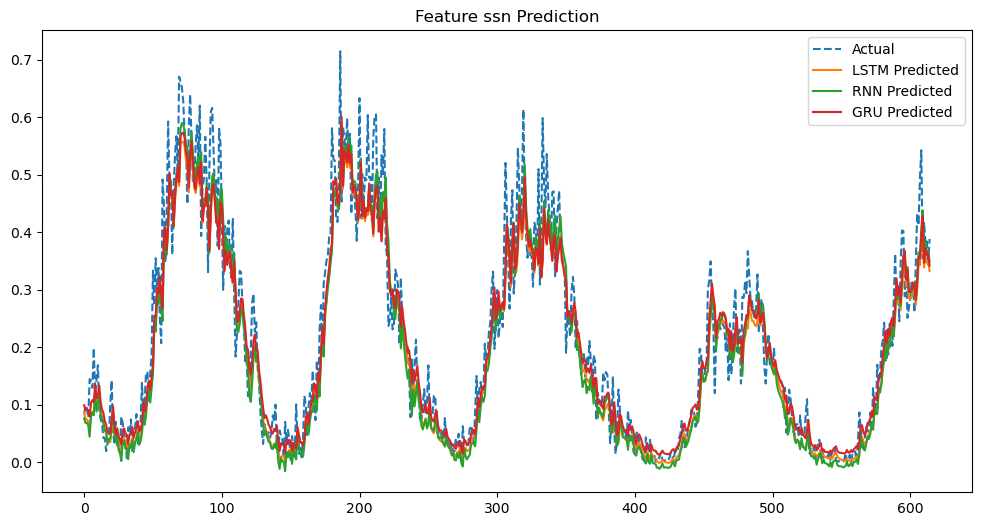

In [19]:
# PLOT PREDCTIONS

feature_idx = 0
plt.figure(figsize=(12, 6))
plt.plot(y_true[:, feature_idx], label="Actual", linestyle="dashed")
plt.plot(lstm_y_pred[:, feature_idx], label="LSTM Predicted")
plt.plot(rnn_y_pred[:, feature_idx], label="RNN Predicted")
plt.plot(gru_y_pred[:, feature_idx], label="GRU Predicted")
plt.legend()
plt.title(f"Feature {df.columns[feature_idx]} Prediction")
plt.savefig('../plots/feature_prediction.png')
plt.show()

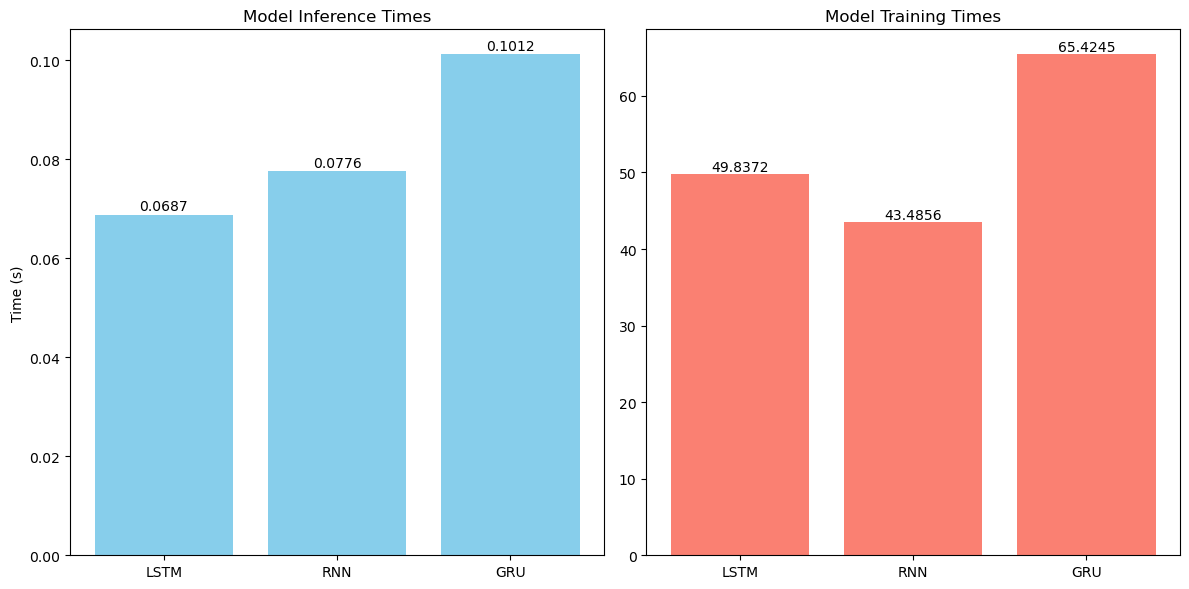

In [20]:
# PLOT EVALUATION AND TRAIN TIME AS BAR CHART

models = ["LSTM", "RNN", "GRU"]

# Assume these variables have been defined with the corresponding times
eval_times = [lstm_eval_time, rnn_eval_time, gru_eval_time]
train_times = [lstm_train_time, rnn_train_time, gru_train_time]

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: Evaluation Times
axs[0].bar(models, eval_times, color='skyblue')
axs[0].set_ylabel("Time (s)")
axs[0].set_title("Model Inference Times")
# Add time values above each bar for evaluation times
for i, t in enumerate(eval_times):
    axs[0].text(i, t + 0.0003, f"{t:.4f}", ha='center', va='bottom')

# Right subplot: Training Times
axs[1].bar(models, train_times, color='salmon')
# axs[1].set_ylabel("Time (s)")
axs[1].set_title("Model Training Times")
# Add time values above each bar for training times
for i, t in enumerate(train_times):
    axs[1].text(i, t + 0.003, f"{t:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../plots/training_inference_time.png')
plt.show()

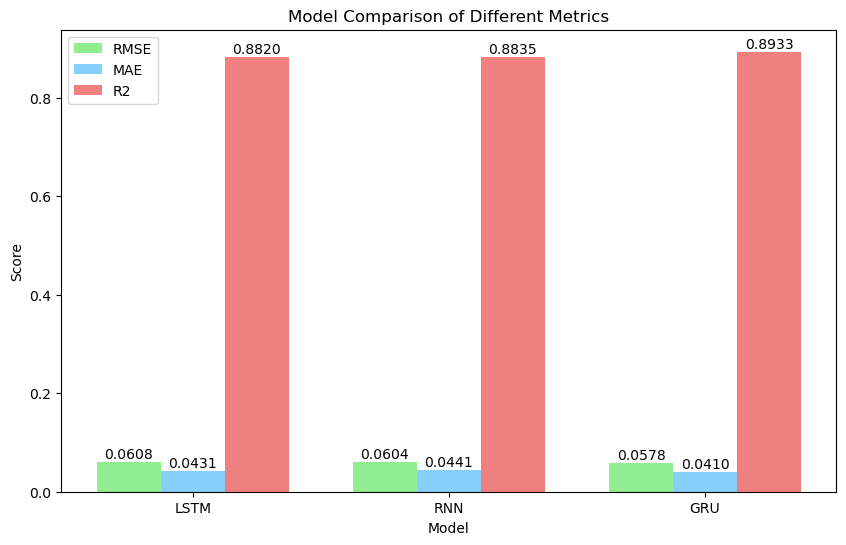

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define metric calculation functions
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Calculate metrics for each model
lstm_rmse = calculate_rmse(y_true, lstm_y_pred)
lstm_mae  = calculate_mae(y_true, lstm_y_pred)
lstm_r2   = calculate_r2(y_true, lstm_y_pred)

rnn_rmse  = calculate_rmse(y_true, rnn_y_pred)
rnn_mae   = calculate_mae(y_true, rnn_y_pred)
rnn_r2    = calculate_r2(y_true, rnn_y_pred)

gru_rmse  = calculate_rmse(y_true, gru_y_pred)
gru_mae   = calculate_mae(y_true, gru_y_pred)
gru_r2    = calculate_r2(y_true, gru_y_pred)

# Organize the scores into a NumPy array (rows: models, columns: metrics)
# Order: RMSE, MAE, R2
scores = np.array([
    [lstm_rmse, lstm_mae, lstm_r2],
    [rnn_rmse,  rnn_mae,  rnn_r2],
    [gru_rmse,  gru_mae,  gru_r2]
])

models = ["LSTM", "RNN", "GRU"]
metrics = ["RMSE", "MAE", "R2"]

# Define positions for the groups and bars
x = np.arange(len(models))  # positions for model groups
width = 0.25  # width of each sub-bar

plt.figure(figsize=(10, 6))

# Plot sub-bars for each metric
plt.bar(x - width, scores[:, 0], width, label="RMSE", color='lightgreen')
plt.bar(x,         scores[:, 1], width, label="MAE",  color='lightskyblue')
plt.bar(x + width, scores[:, 2], width, label="R2",   color='lightcoral')

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Comparison of Different Metrics")
plt.xticks(x, models)
plt.legend()

# Add metric values on top of each bar
for i in range(len(models)):
    plt.text(x[i] - width, scores[i, 0] + 0.001, f"{scores[i, 0]:.4f}", ha='center', va='bottom')
    plt.text(x[i],         scores[i, 1] + 0.001, f"{scores[i, 1]:.4f}", ha='center', va='bottom')
    plt.text(x[i] + width, scores[i, 2] + 0.001, f"{scores[i, 2]:.4f}", ha='center', va='bottom')

plt.savefig('../plots/metric_scores.png')
plt.show()

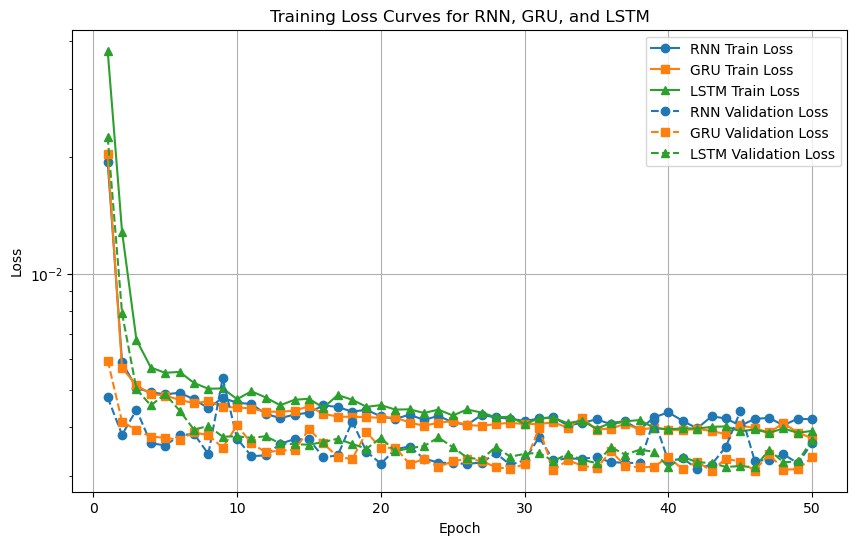

In [22]:
epochs = range(1, len(rnn_train_loss_history) + 1)  # Assuming all histories have the same length

plt.figure(figsize=(10, 6))
plt.plot(epochs, rnn_train_loss_history, marker='o', linestyle='-', label='RNN Train Loss', color='tab:blue')
plt.plot(epochs, gru_train_loss_history, marker='s', linestyle='-', label='GRU Train Loss', color='tab:orange')
plt.plot(epochs, lstm_train_loss_history, marker='^', linestyle='-', label='LSTM Train Loss', color='tab:green')
plt.plot(epochs, rnn_test_loss_history, marker='o', linestyle='--', label='RNN Validation Loss', color='tab:blue')
plt.plot(epochs, gru_test_loss_history, marker='s', linestyle='--', label='GRU Validation Loss', color='tab:orange')
plt.plot(epochs, lstm_test_loss_history, marker='^', linestyle='--', label='LSTM Validation Loss', color='tab:green')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves for RNN, GRU, and LSTM")
plt.yscale('log')  # Set y-axis to a logarithmic scale
plt.grid(True)
plt.legend()
plt.savefig('../plots/loss_curves.png')
plt.show()
